In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from Ricker_functions import *

In [2]:
x_0 = 5 
T = 100
r, sigma, phi = np.exp(2.8), 0.5, 3
theta = np.asarray([r, sigma, phi])

X, Y = simulate_data(x_0, T, theta)

In [5]:
def pMCMC(initial, Y, theta_0, n_particles, n_mcmc, scale, power=1, adapt=True, start_adapt=0.2) :
    
    m = power
    
    theta_dim = len(theta_0)
    log_theta_chain = np.zeros((n_mcmc+1,theta_dim))
    log_theta_chain[0] = np.log(theta_0)
    log_theta_mu, log_theta_m2 = np.log(theta_0), np.log(theta_0)**2
    lls = np.zeros((n_mcmc+1,m)) 
    lls[0] = np.asarray([bootstrap_PF_simple(initial, n_particles, np.exp(log_theta_chain[0]), Y) 
                         for i in range(power)])
    scales = np.ones((n_mcmc+1,theta_dim))
    scales[:] = scale
    accepted = 0
    last_jump = 0
    
    for n in trange(n_mcmc) :
        
        log_theta_proposed = log_theta_chain[n] + scales[n]*npr.randn(theta_dim) 
        ll_proposed = np.asarray([bootstrap_PF_simple(initial, n_particles, np.exp(log_theta_proposed), Y) 
                                  for i in range(power)])
        log_prior_current, log_prior_proposed = log_prior(log_theta_chain[n]), log_prior(log_theta_proposed) 
        log_accept_prob = (np.sum(ll_proposed)-np.sum(lls[n])) \
                          + (log_prior_proposed-log_prior_current) \
                          #+ np.log(np.prod(theta_proposed/theta_chain[n]))
        
        if np.log(npr.rand()) < log_accept_prob :
            lls[n+1], log_theta_chain[n+1] = ll_proposed, log_theta_proposed
            accepted += 1
            latest_jump = n
        else :
            lls[n+1], log_theta_chain[n+1] = lls[n], log_theta_chain[n]
            if n - last_jump > 50 :
                lls[n+1] = np.asarray([bootstrap_PF_simple(initial, n_particles, np.exp(log_theta_chain[n+1]), Y) 
                                       for i in range(power)])
                
        log_theta_mu = ((n+1)*log_theta_mu + log_theta_chain[n+1])/(n+2)
        log_theta_m2 = ((n+1)*log_theta_m2 + log_theta_chain[n+1]**2)/(n+2)
        if adapt :
            if n >= int(n_mcmc*start_adapt) : 
                scales[n+1] = np.sqrt((log_theta_m2 - log_theta_mu**2))*0.7

    print(100*accepted/n_mcmc, "% acceptance rate")
    return log_theta_chain, scales

In [4]:
n_mcmc = 20_000
n_particles = 2*T
burnin = 1000
plt.rcParams['figure.figsize'] = (16, 3.5)

100%|██████████| 20000/20000 [05:50<00:00, 57.06it/s]


32.84 % acceptance rate


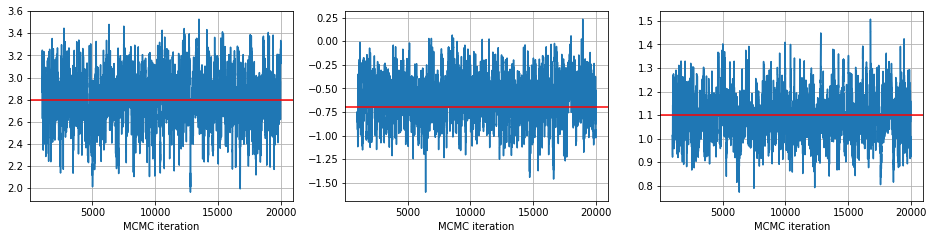

In [5]:
power = 1
scale = np.asarray([0.25, 0.19, 0.10])/np.sqrt(power)
log_theta_chain_pow1, scales_pow1 = pMCMC(x_0, Y, theta, n_particles, n_mcmc, scale, power=power)

for i in range(3) :
    plt.subplot(1,3,i+1)
    plt.plot(np.arange(burnin-1,n_mcmc), log_theta_chain_pow1[burnin:,i])
    plt.axhline(y=np.log(theta)[i], color="red")
    plt.grid(True)
    plt.xlabel("MCMC iteration")

100%|██████████| 20000/20000 [11:52<00:00, 31.20it/s]


31.325 % acceptance rate


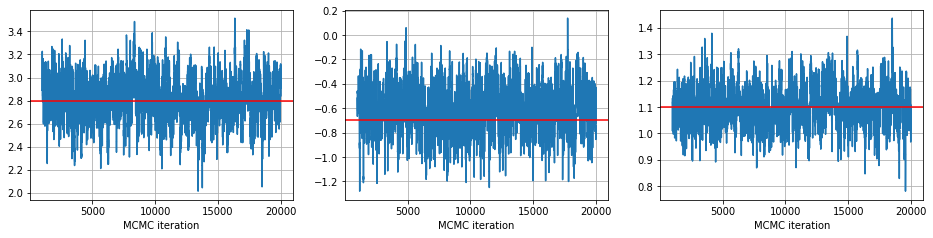

In [6]:
power = 2
scale = np.asarray([0.25, 0.19, 0.10])/np.sqrt(power)
log_theta_chain_pow2, scales_pow2 = pMCMC(x_0, Y, theta, n_particles, n_mcmc, scale, power=power)

for i in range(3) :
    plt.subplot(1,3,i+1)
    plt.plot(np.arange(burnin-1,n_mcmc), log_theta_chain_pow2[burnin:,i])
    plt.axhline(y=np.log(theta)[i], color="red")
    plt.grid(True)
    plt.xlabel("MCMC iteration")

100%|██████████| 20000/20000 [29:35<00:00, 11.27it/s]


31.065 % acceptance rate


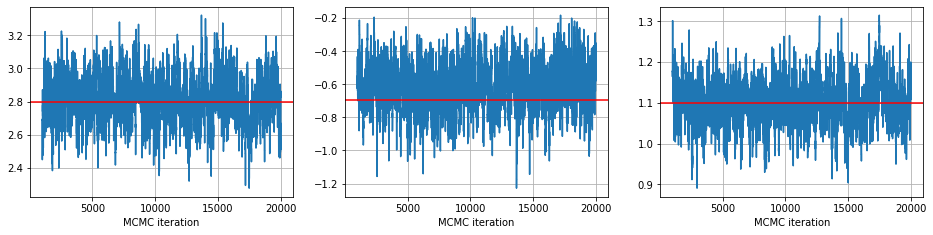

In [7]:
power = 5
scale = np.asarray([0.25, 0.19, 0.10])/np.sqrt(power)
log_theta_chain_pow5, scales_pow5 = pMCMC(x_0, Y, theta, n_particles, n_mcmc, scale, power=5)

for i in range(3) :
    plt.subplot(1,3,i+1)
    plt.plot(np.arange(burnin-1,n_mcmc), log_theta_chain_pow5[burnin:,i])
    plt.axhline(y=np.log(theta)[i], color="red")
    plt.grid(True)
    plt.xlabel("MCMC iteration")

In [8]:
print(np.var(log_theta_chain_pow1,0)/np.var(log_theta_chain_pow2,0))
print(np.var(log_theta_chain_pow1,0)/np.var(log_theta_chain_pow5,0))

[1.51607517 1.40798856 1.55067248]
[2.65013842 2.34959399 2.66784427]


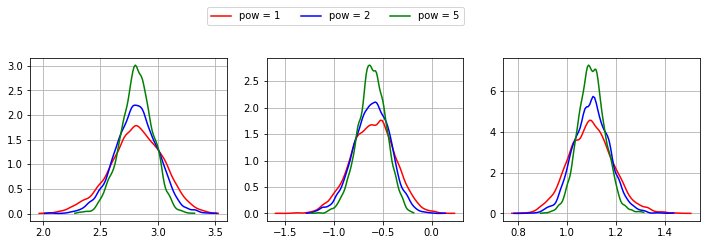

In [9]:
plt.rcParams['figure.figsize'] = (12, 3)
for i in range(3) : 
    plt.subplot(1,3,i+1)
    x_vals = np.linspace(start=np.min(log_theta_chain_pow1[:,i]), 
                         stop=np.max(log_theta_chain_pow1[:,i]), num=100)
    plt.plot(x_vals, gaussian_kde(log_theta_chain_pow1[:,i]) (x_vals), color='r', label="pow = 1")
    x_vals = np.linspace(start=np.min(log_theta_chain_pow2[:,i]), 
                         stop=np.max(log_theta_chain_pow2[:,i]), num=100)
    plt.plot(x_vals, gaussian_kde(log_theta_chain_pow2[:,i]) (x_vals), color='b', label="pow = 2")
    x_vals = np.linspace(start=np.min(log_theta_chain_pow5[:,i]), 
                         stop=np.max(log_theta_chain_pow5[:,i]), num=100)
    plt.plot(x_vals, gaussian_kde(log_theta_chain_pow5[:,i]) (x_vals), color='g', label="pow = 5")
    plt.grid(True)
plt.legend(loc=[-1.5,1.2], ncol=3);

In [10]:
for i in range(3) :
    stat, p = normaltest(log_theta_chain_pow1[:,i])
    print('Statistics = %.3f, p = %.3f' % (stat, p))

Statistics = 140.092, p = 0.000
Statistics = 35.302, p = 0.000
Statistics = 188.883, p = 0.000


In [11]:
for i in range(3) :
    stat, p = normaltest(log_theta_chain_pow2[:,i])
    print('Statistics = %.2f, p = %.3f' % (stat, p))

Statistics = 86.74, p = 0.000
Statistics = 86.41, p = 0.000
Statistics = 135.54, p = 0.000


In [12]:
for i in range(3) :
    stat, p = normaltest(log_theta_chain_pow5[:,i])
    print('Statistics = %.2f, p = %.3f' % (stat, p))

Statistics = 83.95, p = 0.000
Statistics = 126.07, p = 0.000
Statistics = 140.33, p = 0.000


In [2]:
x_0 = 5 
T = 500
r, sigma, phi = np.exp(2.8), 0.5, 3
theta = np.asarray([r, sigma, phi])
X, Y = simulate_data(x_0, T, theta)

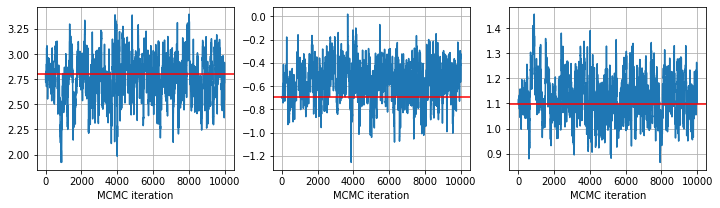

In [9]:
n_particles = T 
n_mcmc = 10_000

scale = np.asarray([0.25, 0.19, 0.10])/np.sqrt(10)
log_theta_chain, scales = pMCMC(x_0, Y, theta, n_particles, n_mcmc, scale)

plt.rcParams['figure.figsize'] = (12, 3)
for i in range(3) :
    plt.subplot(1,3,i+1)
    plt.plot(np.arange(1+n_mcmc), log_theta_chain[:,i])
    plt.axhline(y=np.log(theta)[i], color="red")
    plt.grid(True)
    plt.xlabel("MCMC iteration")

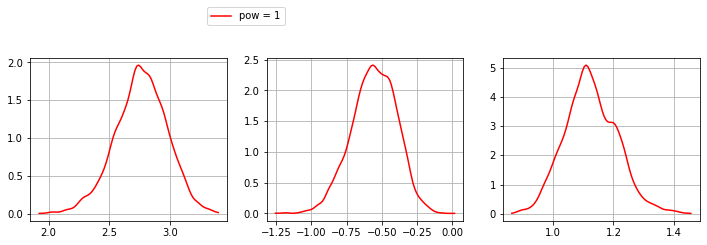

In [10]:
plt.rcParams['figure.figsize'] = (12, 3)
for i in range(3) : 
    plt.subplot(1,3,i+1)
    x_vals = np.linspace(start=np.min(log_theta_chain[:,i]), 
                         stop=np.max(log_theta_chain[:,i]), num=100)
    plt.plot(x_vals, gaussian_kde(log_theta_chain[:,i]) (x_vals), color='r', label="pow = 1")
    plt.grid(True)
plt.legend(loc=[-1.5,1.2], ncol=3);

In [11]:
for i in range(3) :
    stat, p = normaltest(log_theta_chain[:,i])
    print('Statistics = %.3f, p = %.3f' % (stat, p))

Statistics = 112.472, p = 0.000
Statistics = 100.208, p = 0.000
Statistics = 99.051, p = 0.000
